https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Create Transfomation for Dataset

In [3]:
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# Load Dataset from library

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

Files already downloaded and verified
Files already downloaded and verified


# Load Dataset into Dataloader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

# View and Verify Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([3, 32, 32])


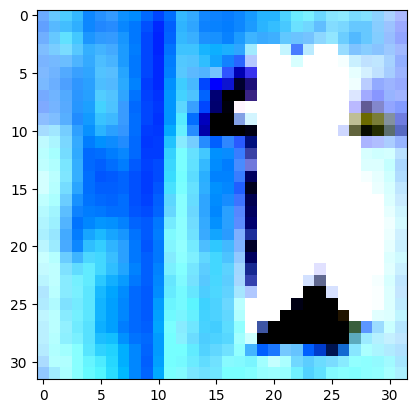

In [32]:
import matplotlib.pyplot as plt

for img, targ in train_loader:
    print(img.size())
    print(targ.size())
    img_single = img[0]
    print(img_single.size())
    plt.imshow(img_single.T)
    break

# Create Model

![](https://blog.paperspace.com/content/images/size/w1000/2021/05/image-32.png)

In [9]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [10]:
model = ConvNeuralNet(num_classes).to(device)
print(model)

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Create Loss and Optim

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# Training Montage

In [12]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 1.7084
Epoch [2/20], Loss: 1.2225
Epoch [3/20], Loss: 1.5436
Epoch [4/20], Loss: 0.9692
Epoch [5/20], Loss: 2.1287
Epoch [6/20], Loss: 0.8969
Epoch [7/20], Loss: 1.3061
Epoch [8/20], Loss: 0.8049
Epoch [9/20], Loss: 1.0891
Epoch [10/20], Loss: 0.7078
Epoch [11/20], Loss: 0.5660
Epoch [12/20], Loss: 0.5641
Epoch [13/20], Loss: 0.7317
Epoch [14/20], Loss: 1.0506
Epoch [15/20], Loss: 0.7200
Epoch [16/20], Loss: 1.1484
Epoch [17/20], Loss: 0.3465
Epoch [18/20], Loss: 1.0061
Epoch [19/20], Loss: 0.2850
Epoch [20/20], Loss: 0.1617


# Testing Prediction

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))

Accuracy of the network on the 50000 train images: 83.212 %
